In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# 修正的RMSSE計算函數，加入epsilon以避免除零錯誤
def rmsse(preds, true, train, epsilon=1e-10):
    n = len(true)
    squared_errors = np.square(preds - true)
    mean_squared_errors = np.mean(squared_errors)
    mean_squared_train = np.mean(np.square(train[:-1] - train[1:]))
    return np.sqrt(mean_squared_errors / (mean_squared_train + epsilon))

# 定義自訂RMSSE評估函數給模型使用
def custom_rmsse_eval(preds, dtrain):
    labels = dtrain.get_label()
    train_series = dtrain.get_weight()  # 在這裡，我們使用weight來傳遞訓練集資料
    rmsse_val = rmsse(preds, labels, train_series)
    return 'rmsse', rmsse_val, False

# RMSSE for xgb
def custom_rmsse_eval_xgb(preds, dtrain):
    labels = dtrain.get_label()

    # 计算平方误差
    squared_errors = np.square(preds - labels)
    mean_squared_errors = np.mean(squared_errors)

    # 计算训练数据的均方差
    train_series = dtrain.get_weight()
    if len(train_series) <= 1:
        return 'rmsse', float('nan')

    mean_squared_train = np.mean(np.square(train_series[:-1] - train_series[1:])) + 1e-10

    rmsse = np.sqrt(mean_squared_errors / mean_squared_train)
    return 'rmsse', rmsse

In [4]:
# 資料讀取
data = pd.read_csv('/content/drive/MyDrive/Dissertation/DissertationData/hobbies.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5650 entries, 0 to 5649
Columns: 1941 entries, d_1 to d_1941
dtypes: int64(1941)
memory usage: 83.7 MB


In [6]:
data.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,...,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000
mean,0.666195,0.594159,0.474690,0.472389,0.321062,0.569912,0.521062,0.705487,0.513097,0.462832,...,0.685133,0.866018,0.887788,0.624425,0.642301,0.661947,0.615044,0.733274,0.943894,0.934513
std,2.788479,2.415373,2.317546,2.087152,1.658571,2.720889,2.528716,3.021840,2.069065,2.343516,...,1.829561,2.311913,2.239306,1.706103,1.750608,1.900253,2.002818,1.780137,2.708902,2.506065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,54.000000,73.000000,67.000000,38.000000,53.000000,74.000000,55.000000,78.000000,47.000000,50.000000,...,30.000000,43.000000,38.000000,45.000000,43.000000,50.000000,84.000000,32.000000,63.000000,80.000000


In [6]:
# 2. 特徵工程
data['mean_sales'] = data.mean(axis=1)
data['std_sales'] = data.std(axis=1)
data['max_sales'] = data.max(axis=1)
data['min_sales'] = data.min(axis=1)

In [8]:
# 3.1. 按時間順序分割資料 (80% 訓練集, 20% 測試集)
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index].copy()  # 前 80% 為訓練集 # DataFrame
test_data = data.iloc[split_index:].copy()   # 後 20% 為測試集

# 2. 從訓練集中進一步分割出訓練與驗證集 (80% 的訓練資料)
train_size = int(len(train_data) * 0.8)
X_train = train_data.iloc[:train_size].drop(columns=['mean_sales', 'std_sales', 'max_sales', 'min_sales']).copy()
y_train = train_data.iloc[:train_size]['mean_sales'].copy()

# 驗證集 (訓練集的最後 20%)
X_val = train_data.iloc[train_size:].drop(columns=['mean_sales', 'std_sales', 'max_sales', 'min_sales']).copy()
y_val = train_data.iloc[train_size:]['mean_sales'].copy()

# 3. 處理測試集資料
X_test = test_data.drop(columns=['mean_sales', 'std_sales', 'max_sales', 'min_sales']).copy()
y_test = test_data['mean_sales'].copy()

In [ ]:
# # 打印 y_test 和各預測結果的長度
# print(f"Number of test samples: {len(X_train)}")
# print(f"Number of LightGBM predictions: {len(y_train)}")
# print(f"Number of XGBoost predictions: {len(X_test)}")
# print(f"Number of Pooled Regression predictions: {len(y_test)}")

In [9]:
# 5. 模型訓練與交叉驗證
rmsse_scores = {'lightgbm': [], 'xgboost': [], 'pr': []}

In [10]:
# 學習率設定
learning_rates = [0.001, 0.0001, 0.00001]

In [11]:
# 最終檢查 y_train 和 y_test 是否成功生成
print("y_train:", y_train.head())
print("y_test:", y_test.head())

y_train: 0    0.326121
1    0.257599
2    0.159196
3    1.719217
4    0.972694
Name: mean_sales, dtype: float64
y_test: 4520    0.060793
4521    0.409067
4522    0.057702
4523    0.300361
4524    0.311695
Name: mean_sales, dtype: float64


# ***Training Models***

In [12]:
train_window_size = 200  # 訓練窗口大小
val_window_size = 50     # 驗證窗口大小

In [13]:
# 模型1: LightGBM
for lr in learning_rates:
    for start_index in range(train_window_size, len(X_train) - val_window_size, val_window_size):
        X_tr = X_train.iloc[start_index - train_window_size:start_index]
        y_tr = y_train.iloc[start_index - train_window_size:start_index]
        X_val = X_train.iloc[start_index:start_index + val_window_size]
        y_val = y_train.iloc[start_index:start_index + val_window_size]

        lgbm_params = {
            'objective': 'regression',
            'verbosity': -1,
            'learning_rate': lr
        }

        # 使用訓練數據創建LightGBM資料集
        train_data_lgb = lgb.Dataset(X_tr, label=y_tr, weight=y_tr)  # weight參數用來傳遞訓練數據
        val_data_lgb = lgb.Dataset(X_val, label=y_val, reference=train_data_lgb, weight=y_val)

        lgbm = lgb.train(
            lgbm_params,
            train_data_lgb,
            valid_sets=[train_data_lgb, val_data_lgb],  # 設置驗證集
            valid_names=['train', 'valid'],
            feval=custom_rmsse_eval,  # 使用自訂的RMSSE評估函數
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)]  # 設置早停和日誌回調
        )

        # 在模型訓練結束後，獲取最佳的驗證 RMSSE
        best_rmsse = lgbm.best_score['valid']['rmsse']
        print("+---------------------------------------------------------------------+")
        rmsse_scores['lightgbm'].append((lr, best_rmsse))

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l2: 5.71267	train's rmsse: 1.18606	valid's l2: 9.38601	valid's rmsse: 0.897196
+---------------------------------------------------------------------+
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l2: 6.18817	train's rmsse: 1.15348	valid's l2: 13.255	valid's rmsse: 0.833328
+---------------------------------------------------------------------+
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l2: 8.23887	train's rmsse: 1.21845	valid's l2: 17.7914	valid's rmsse: 0.98433
+---------------------------------------------------------------------+
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's l2: 10.5937	train's rmsse: 1.21475	valid's l2: 13.9577	va

In [14]:
# 模型2: XGBoost
for lr in learning_rates:
    for start_index in range(train_window_size, len(X_train) - val_window_size, val_window_size):
        X_tr = X_train.iloc[start_index - train_window_size:start_index]
        y_tr = y_train.iloc[start_index - train_window_size:start_index]
        X_val = X_train.iloc[start_index:start_index + val_window_size]
        y_val = y_train.iloc[start_index:start_index + val_window_size]

        dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val, weight=y_val)

        xgbm = xgb.train(
            params={
                'objective': 'reg:squarederror',
                'learning_rate': lr,
            },
            dtrain=dtrain,
            evals=[(dval, "validation")],
            custom_metric=custom_rmsse_eval_xgb,  # 使用自定义的 RMSSE 评估函数
            early_stopping_rounds=10,
            verbose_eval=False
        )

        # 获取最后一轮的 RMSSE 分数
        evals_result = xgbm.eval_set([(dval, "validation")], iteration=xgbm.best_iteration)
        best_rmsse = evals_result.split('\t')[1].split(':')[1]
        best_rmsse = float(best_rmsse)

        print("+---------------------------------------------+")
        rmsse_scores['xgboost'].append((lr, best_rmsse))
        print("learning rate:", lr)
        print("rmsse_score:", best_rmsse)

+---------------------------------------------+
learning rate: 0.001
rmsse_score: 3.1563263159796087
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 3.813385186398224
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 4.32647256496491
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 3.9638516940898936
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 3.5905498707403005
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 3.967056448801417
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 3.680236311792589
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 2.3934662840571046
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 1.4549126973379825
+---------------------------------------------+
learning rate: 0.001
rmsse_score: 1.589583737358

In [15]:
# 模型3: PR模型 (線性迴歸，無學習率)
for start_index in range(train_window_size, len(X_train) - val_window_size, val_window_size):
    X_tr = X_train.iloc[start_index - train_window_size:start_index]
    y_tr = y_train.iloc[start_index - train_window_size:start_index]
    X_val = X_train.iloc[start_index:start_index + val_window_size]
    y_val = y_train.iloc[start_index:start_index + val_window_size]

    pr_model = LinearRegression()
    pr_model.fit(X_tr, y_tr)

    val_preds = pr_model.predict(X_val)
    rmsse_score = rmsse(val_preds, y_val, y_tr)
    rmsse_scores['pr'].append(('n/a', rmsse_score))

In [16]:
import joblib #保存models

In [17]:
# 假設 rmsse_scores 包含了所有模型的 RMSSE 分數
final_models = {}

# 1. LightGBM
lightgbm_best_score = float('inf')
lightgbm_best_lr = None

for lr, score in rmsse_scores['lightgbm']:
    if score < lightgbm_best_score:
        lightgbm_best_score = score
        lightgbm_best_lr = lr

final_models['lightgbm'] = {'learning_rate': lightgbm_best_lr, 'rmsse': lightgbm_best_score}

# 2. XGBoost
xgboost_best_score = float('inf')
xgboost_best_lr = None

for lr, score in rmsse_scores['xgboost']:
    if score < xgboost_best_score:
        xgboost_best_score = score
        xgboost_best_lr = lr

final_models['xgboost'] = {'learning_rate': xgboost_best_lr, 'rmsse': xgboost_best_score}

# 3. 其他模型（假設是 RandomForest）
pr_best_score = float('inf')
pr_best_lr = None

for lr, score in rmsse_scores['pr']:
    if score < xgboost_best_score:
        xgboost_best_score = score
        xgboost_best_lr = lr

final_models['pr'] = {'learning_rate': xgboost_best_lr, 'rmsse': xgboost_best_score}

# 顯示每個模型中最好的結果
for model_name, model_info in final_models.items():
    print(f"最好的模型是: {model_name}")
    print(f"學習率: {model_info['learning_rate']}, RMSSE: {model_info['rmsse']}")
    print("+---------------------------------------------+")

最好的模型是: lightgbm
學習率: 0.001, RMSSE: 0.679443725880478
+---------------------------------------------+
最好的模型是: xgboost
學習率: 0.001, RMSSE: 0.7021651165981669
+---------------------------------------------+
最好的模型是: pr
學習率: 0.001, RMSSE: 0.7021651165981669
+---------------------------------------------+


In [21]:
# 1. LightGBM - 選擇最佳參數
lightgbm_best_score = float('inf')
lightgbm_best_lr = None

for lr, score in rmsse_scores['lightgbm']:
    if score < lightgbm_best_score:
        lightgbm_best_score = score
        lightgbm_best_lr = lr

# 假設 best_lr 已經從之前的交叉驗證中確定
lgbm_params = {
    'objective': 'regression',
    'learning_rate': lightgbm_best_lr,  # 使用最佳學習率
    'verbosity': -1
}

# 使用完整的訓練數據創建LightGBM資料集
train_data_lgb = lgb.Dataset(X_train, label=y_train, weight=y_train)  # 使用完整的訓練數據

# 訓練最終的LightGBM模型
lightgbm_final = lgb.train(
    params=lgbm_params,
    train_set=train_data_lgb,  # 設置訓練集
    num_boost_round=1000,  # 設置訓練的迭代次數
    valid_sets=[train_data_lgb],  # 可以設置驗證集，這裡我們使用訓練集本身
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]  # 通過callbacks來設置early stopping和日誌打印
)

# 保存 LightGBM 模型
joblib.dump(lightgbm_final, '/content/drive/MyDrive/Dissertation/DissertationData/BestModels/lightgbm_final_model.pkl')
final_models['lightgbm'] = {'model': lightgbm_final, 'learning_rate': lightgbm_best_lr, 'rmsse': lightgbm_best_score}

/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[10]	training's l2: 8.11748
[20]	training's l2: 7.97755
[30]	training's l2: 7.84002
[40]	training's l2: 7.70274
[50]	training's l2: 7.56843
[60]	training's l2: 7.43608
[70]	training's l2: 7.30644
[80]	training's l2: 7.17902
[90]	training's l2: 7.05404
[100]	training's l2: 6.93009
[110]	training's l2: 6.80771
[120]	training's l2: 6.68748
[130]	training's l2: 6.56953
[140]	training's l2: 6.45372
[150]	training's l2: 6.33998
[160]	training's l2: 6.22852
[170]	training's l2: 6.11899
[180]	training's l2: 6.01153
[190]	training's l2: 5.90609
[200]	training's l2: 5.80269
[210]	training's l2: 5.70118
[220]	training's l2: 5.6018
[230]	training's l2: 5.5041
[240]	training's l2: 5.40823
[250]	training's l2: 5.31407
[260]	training's l2: 5.22134
[270]	training's l2: 5.13032
[280]	training's l2: 5.04095
[290]	training's l2: 4.95327
[300]	training's l2: 4.86723
[310]	training's l2: 4.78288
[320]	training's l2: 4.70011
[330]	training's l2: 4.61881
[340]	training's l2: 4.53895
[350]	training's l2: 4.46

In [22]:
# 2. XGBoost - 選擇最佳參數
xgboost_best_score = float('inf')
xgboost_best_lr = None

for lr, score in rmsse_scores['xgboost']:
    if score < xgboost_best_score:
        xgboost_best_score = score
        xgboost_best_lr = lr

# 重新訓練 XGBoost 模型
xgboost_final = xgb.train(
    params={
        'objective': 'reg:squarederror',
        'learning_rate': xgboost_best_lr,
    },
    dtrain=dtrain
)
# 保存 XGBoost 模型
joblib.dump(xgboost_final, '/content/drive/MyDrive/Dissertation/DissertationData/BestModels/xgboost_final_model.pkl')
final_models['xgboost'] = {'model': xgboost_final, 'learning_rate': xgboost_best_lr, 'rmsse': xgboost_best_score}

In [23]:
# 使用完整的訓練數據重新訓練Pooled Regression模型
pooled_regression_final = LinearRegression()
pooled_regression_final.fit(X_train, y_train)

# 保存最終的Pooled Regression模型
joblib.dump(pooled_regression_final, '/content/drive/MyDrive/Dissertation/DissertationData/BestModels/pooled_regression_final_model.pkl')
final_models['pooled_regression'] = {'model': pooled_regression_final, 'rmsse': None}

In [24]:
lightgbm_model = joblib.load('/content/drive/MyDrive/Dissertation/DissertationData/BestModels/lightgbm_final_model.pkl')
xgboost_model = joblib.load('/content/drive/MyDrive/Dissertation/DissertationData/BestModels/xgboost_final_model.pkl')
pooled_regression_model = joblib.load('/content/drive/MyDrive/Dissertation/DissertationData/BestModels/pooled_regression_final_model.pkl')

In [25]:
y_test_pred_lgb = lightgbm_model.predict(X_test)
y_test_pred_xgb = xgboost_model.predict(xgb.DMatrix(X_test))
y_test_pred_pr = pooled_regression_model.predict(X_test)

In [62]:
sample_range = 100  # 根據需要選擇樣本數量

# 提取前樣本範圍的數據
y_test_sample = y_test.head(sample_range).values
y_test_pred_lgb_sample = y_test_pred_lgb[:sample_range]
y_test_pred_xgb_sample = y_test_pred_xgb[:sample_range]
y_test_pred_pr_sample = y_test_pred_pr[:sample_range]

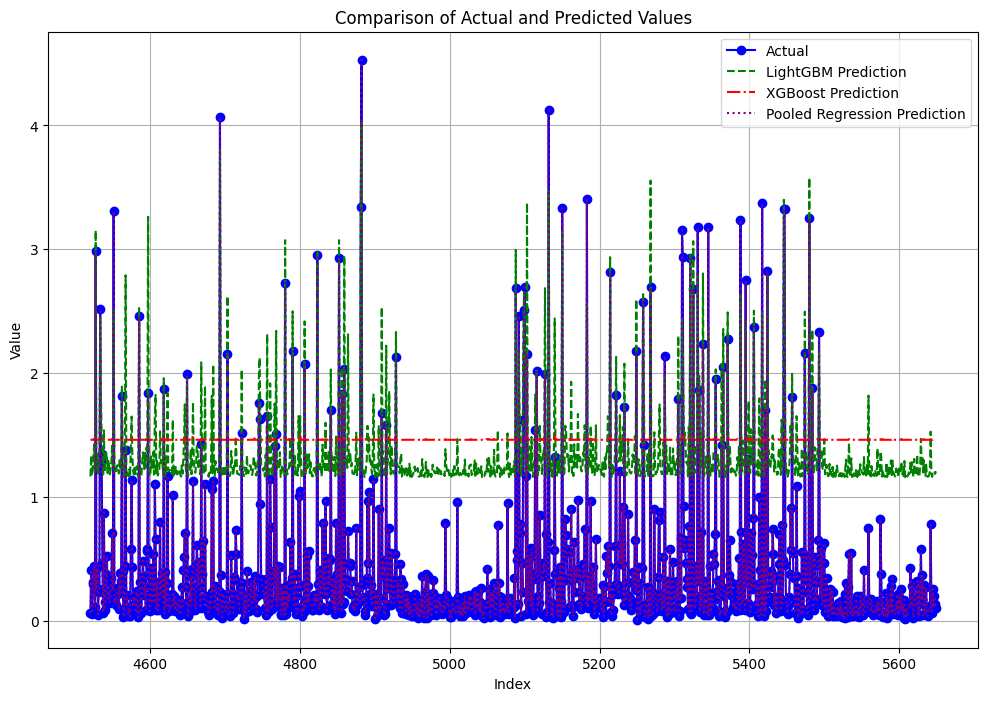

In [64]:
# 繪製圖形的示例代碼
plt.figure(figsize=(12, 8))

# 實際值
plt.plot(y_test.index, y_test, label='Actual', marker='o', color='blue')

# LightGBM 預測值
plt.plot(y_test.index, y_test_pred_lgb, label='LightGBM Prediction', linestyle='--', color='green')

# XGBoost 預測值
plt.plot(y_test.index, y_test_pred_xgb, label='XGBoost Prediction', linestyle='-.', color='red')

# Pooled Regression 預測值
plt.plot(y_test.index, y_test_pred_pr, label='Pooled Regression Prediction', linestyle=':', color='purple')

# 設置圖例
plt.legend()

# 設置標題
plt.title('Comparison of Actual and Predicted Values')

# 設置 X 軸標籤
plt.xlabel('Index')

# 設置 Y 軸標籤
plt.ylabel('Value')

# 啟用網格
plt.grid(True)

# 顯示圖形
plt.show()

In [43]:
weights = y_train.groupby(y_train.index).mean().values

# 確保 weights 與 y_test 的大小匹配
weights = weights[:len(y_test)]  # 或者根據實際需要調整

In [45]:
def calculate_wrmsse(y_true, y_pred, y_train, weights=None):
    # 計算 S 均方誤差（MSE）
    mse = np.mean((y_true - y_pred) ** 2, axis=0)

    # 計算 RMSSE
    denominator = np.mean(np.diff(y_train, axis=0) ** 2, axis=0)
    rmsse = np.sqrt(mse / denominator)

    # 計算加權 RMSSE（如果權重存在）
    if weights is not None:
        wrmsse = np.sum(weights * rmsse) / np.sum(weights)
    else:
        wrmsse = np.mean(rmsse)

    return wrmsse

wrmsse_lgb = calculate_wrmsse(y_test, y_test_pred_lgb, y_train, weights)
wrmsse_xgb = calculate_wrmsse(y_test, y_test_pred_xgb, y_train, weights)
wrmsse_pr = calculate_wrmsse(y_test, y_test_pred_pr, y_train, weights)

print(f'LightGBM 测试集 WRMSSE: {wrmsse_lgb}')
print(f'XGBoost 测试集 WRMSSE: {wrmsse_xgb}')
print(f'Pooled Regression 测试集 WRMSSE: {wrmsse_pr}')

LightGBM 测试集 WRMSSE: 0.6513371168597627
XGBoost 测试集 WRMSSE: 0.8030898018700582
Pooled Regression 测试集 WRMSSE: 1.237964453573033e-15
